In [ ]:
##############################################################################
## Fundamentals for pratical Text Analytics - classification tasks and applications
##
## Learning goals:
##                 - reinforce text as a robust dataset via language modeling and understanding
##                 - python packages for handling our corpus for these exploratory tasks
##                 - a little more spacy
##                 - text classification discussions and include it in other pipelines
##############################################################################

In [ ]:
# installs 
! pip install newspaper3k
! pip install -U spacy
! pip install afinn
! pip install spacytextblob
! pip install pysrt
! pip install textdescriptives
! pip install tokenwiser

## you may need to restart the colab kernel

In [ ]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# text imports
import spacy
from spacy import cli
from spacytextblob.spacytextblob import SpacyTextBlob
import textdescriptives as td
import tokenwiser

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import gensim

from afinn import Afinn
from newspaper import Article

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
##################################### WARMUP Exercise
##################################### 
## there is a file located below: 
##     https://storage.googleapis.com/qst-datasets/subtitles/Shrek-2001.srt
## there is also some started code below
## calculate the sentiment over the course of the movie script (Shrek)
## plot the sentiment arc over the movie
##
## Some started code has been provided to you

In [ ]:
# 0. get the file - the file in the browser will auto download
#    just make sure you have the file in your working directory

# or if on colab
! wget https://storage.googleapis.com/qst-datasets/subtitles/Shrek-2001.srt

In [ ]:
# 1. get the file and parse

import pysrt
subs = pysrt.open('Shrek-2001.srt', encoding='iso-8859-1')

In [ ]:
# the first message -- each entry has a text attribute we can use to build our corpus
print(subs[0].text)

Once upon a time there
was a lovely princess.


In [ ]:
len(subs)

1097

In [ ]:
# make a corpus (list of texts)
corpus = [sub.text for sub in subs]

corpus[:3]

['Once upon a time there\nwas a lovely princess.',
 'But she had an enchantment upon her\nof a fearful sort,',
 "which could only be broken\nby Love's first kiss."]

In [ ]:
# score the sentiment
# Afinn

afinn = Afinn("en")

sents = [afinn.score(doc) for doc in corpus]


In [ ]:
sents[:3]

[3.0, -2.0, 4.0]

In [ ]:
# hypothesis - can we use sentiment analysis to proxy
# for the arc of a story

df = pd.DataFrame({'scene':corpus, 'sent':sents})

In [ ]:
df.head(3)

,scene,sent
0,Once upon a time there\nwas a lovely princess.,3.0
1,But she had an enchantment upon her\nof a fear...,-2.0
2,which could only be broken\nby Love's first kiss.,4.0


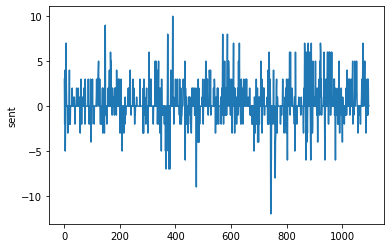

In [ ]:
# plot
sns.lineplot(x=df.index, y="sent", data=df)

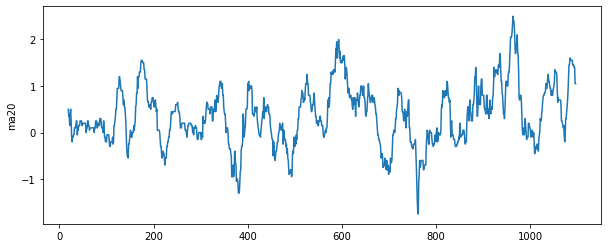

In [ ]:
# moving average

df['ma20'] = df.sent.rolling(20).mean()
plt.figure(figsize=(10,4))
sns.lineplot(x=df.index, y="ma20", data=df)
plt.show()

In [ ]:
##################################### Quick Recap - Tokenization
##################################### 
## nltk has built in tokenizers
## lets extend what we saw in the context of a sklearn flow

from nltk.tokenize import word_tokenize, TweetTokenizer

In [ ]:
# a simple corpus

corpus = ['Brock has a dog named Bodhi', 
          '@brocktibert loves to write code in #pydata']

In [ ]:
# word tokenizer is basic
# this is helpful as a starting point -- we will see some tools want a list of lists, with each entry considered a token

[word_tokenize(doc) for doc in corpus]



[['Brock', 'has', 'a', 'dog', 'named', 'Bodhi'],
 ['@', 'brocktibert', 'loves', 'to', 'write', 'code', 'in', '#', 'pydata']]

In [ ]:
# of course, we could always go to base python
[doc.split() for doc in corpus]


[['Brock', 'has', 'a', 'dog', 'named', 'Bodhi'],
 ['@brocktibert', 'loves', 'to', 'write', 'code', 'in', '#pydata']]

In [ ]:
# we could use TweetTokenizer
social = TweetTokenizer()

[social.tokenize(doc) for doc in corpus]


[['Brock', 'has', 'a', 'dog', 'named', 'Bodhi'],
 ['@brocktibert', 'loves', 'to', 'write', 'code', 'in', '#pydata']]

In [ ]:
# roll it into sklearn

def parser(text):
  social = TweetTokenizer()
  return social.tokenize(text)

cv = CountVectorizer(tokenizer=parser)
cv.fit(corpus)

dtm = cv.transform(corpus)

df = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())


In [ ]:
df

,#pydata,@brocktibert,a,bodhi,brock,code,dog,has,in,loves,named,to,write
0,0,0,1,1,1,0,1,1,0,0,1,0,0
1,1,1,0,0,0,1,0,0,1,1,0,1,1


In [ ]:
##################################### Your turn
###
### tokenize the shrek movie script corpus using word_tokenize from nltk
### TIPS:
###      try word_tokenize on a single piece of text
###      roll your own function to tokenize
###      use count vectorizer
###      put it back into a dataframe for review --- this isn't usually necessary, but helps with the intuition of what is happening!

In [ ]:
# re-create my corpus
corpus = [sub.text for sub in subs]

In [ ]:
# the function
def shrek(text):
  # we could do all sorts of preprocessing
  return word_tokenize(text)

cv = CountVectorizer(tokenizer=shrek)
cv.fit(corpus)

dtm = cv.transform(corpus)

shrek_df = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())

shrek_df.iloc[:5, :5]

,!,','','cause,'course
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [ ]:
shrek_df.shape

(1097, 1385)

In [ ]:
### The big point here is that a number of tools may look
### for our a list of lists, including scikit learn.
### I bring this up for spacy, where the parsed doc is an object
### but if we have to, we can simply coerce to that format.

In [ ]:
##################################### Key Words in Context - Concordance
###
### powerful tool to look at a set of text (full corpus) and look for
### words before/after
###
### helpful for eda, look for patterns to help support data annotation, etc.



In [ ]:
# get the data -- airline tweets

SQL = "SELECT * FROM `questrom.datasets.airlines-tweets`"
PROJ = "questrom"
tweets = pd.read_gbq(SQL, PROJ)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=fNOpyAN6Xu7Xp4I8IV6moRx0LRDXR9&prompt=consent&access_type=offline
Enter the authorization code: 4/1AX4XfWjmc_QDTflgpz70tZWrv8GRfPqbDO-y0nwghK-idTsBAIl2l1hi85E


In [ ]:
# sample 
tweets.sample(3)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11561,569310913079214080,negative,1.0,Late Flight,1.0000,US Airways,None,MattClement,None,0,@USAirways Looks like I'm already delayed and ...,None,2015-02-21 17:41:13 -0800,"Troy, NY",Eastern Time (US & Canada)
2393,569444898660691968,negative,1.0,Late Flight,0.3488,United,None,throthra,None,0,@united thanks for letting me sleep at DIA to ...,None,2015-02-22 02:33:38 -0800,None,None
2589,569552658010210305,negative,1.0,Late Flight,0.6611,Delta,None,arthurhasher,None,0,@JetBlue So what about the plane stuck in Newb...,None,2015-02-22 09:41:50 -0800,Long Island - Arizona,None


In [ ]:
# text -- acts like a big corpus
from nltk import Text

# get the text into the correct format
tweet_text = tweets.text.tolist()

# put into a corpus (as if it were 1 big file, ignoring that we have intents)

corpus = " ".join(tweet_text)

# tokenize

tokens = nltk.word_tokenize(corpus)
len(tokens)

# put the corpus into a Text object.  
# some nice features when we consider the corpus a blob of text that lacks 
# structure like sentences, or by user, etc.  Just the text combined like a book chapter.

text = Text(tokens)



In [ ]:
# look for the context of words
# Key work in context, or concordance

## flight / delay / service / baggage / boston
text.concordance("baggage", width=80, lines=10)


Displaying 10 of 226 matches:
 assisting me over the phone with a baggage claim issue today . She really went
t see where it talks about military baggage fees . Can you please guide me . Th
ag included in the standard checked baggage next to the snowboard bag ? @ unite
. Was wondering , Does United waive baggage fees for military personnel . Thank
ited A3 Gold . So the international baggage limit apply when booked on 1 ticket
t to get her a safe flight with her baggage soon ! @ united ca n't wait ! ! ! 7
tomer service provided by Janet and baggage employee Karen . You have 2 wonderf
est airline around ! Just hate when baggage room runs out.. My now checked bag 
d customer service professionals at baggage claim are OUTSTANDING ! ! Thank you
r planes ? I know you have a lot of baggage ... But i want you to know i really


In [ ]:
##################################### Text Exploratory Descriptive Stats
##################################### https://github.com/HLasse/TextDescriptives
##
## desctriptive stats for a piece of text
## plays well with spacy and dataframes
## think of this as a way to featurize our text beyond tokenization
## depending on our tasks, this could help with downstream classification tasks



In [ ]:
# download the small spacy language model

model = "en_core_web_sm"
cli.download(model)
nlp = spacy.load(model)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


![](https://d33wubrfki0l68.cloudfront.net/3ad0582d97663a1272ffc4ccf09f1c5b335b17e9/7f49c/pipeline-fde48da9b43661abcdf62ab70a546d71.svg)

In [ ]:
# what do we have 
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
# lets add additional components

nlp.add_pipe("spacytextblob")
nlp.add_pipe("textdescriptives") 

In [ ]:
# review the robust NLP pipeline
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'spacytextblob',
 'descriptive_stats',
 'readability',
 'dependency_distance',
 'pos_stats',
 'textdescriptives']

In [ ]:
# lets parse our tweets dataset from earlier
tweets.shape

(14640, 15)

In [ ]:
# lets take a sample of 100 to help keep this "fast"
# worth noting that real datasets and balancing runtimes and performance can be at odds at times

docs = nlp.pipe(tweets.text.sample(100, random_state=820))

In [ ]:
# extract the summary stats from the tweet docs
# every tweet is being run through the nlp pipeline

tweets_df = td.extract_df(docs)


In [ ]:
# what do we have
tweets_df.shape

(100, 45)

In [ ]:
# review
tweets_df.head(3)

,text,token_length_mean,token_length_median,token_length_std,sentence_length_mean,sentence_length_median,sentence_length_std,syllables_per_token_mean,syllables_per_token_median,syllables_per_token_std,n_tokens,n_unique_tokens,proportion_unique_tokens,n_characters,n_sentences,flesch_reading_ease,flesch_kincaid_grade,smog,gunning_fog,automated_readability_index,coleman_liau_index,lix,rix,dependency_distance_mean,dependency_distance_std,prop_adjacent_dependency_relation_mean,prop_adjacent_dependency_relation_std,pos_prop_X,pos_prop_PUNCT,pos_prop_NUM,pos_prop_AUX,pos_prop_PART,pos_prop_VERB,pos_prop_PRON,pos_prop_NOUN,pos_prop_CCONJ,pos_prop_SCONJ,pos_prop_DET,pos_prop_ADJ,pos_prop_PROPN,pos_prop_ADP,pos_prop_ADV,pos_prop_SYM,pos_prop_SPACE,pos_prop_INTJ
0,@AmericanAir ...2/2 doesn't help me.,5.000000,4.0,3.577709,5.0,5.0,0.0,1.400000,1.0,0.800000,5,5,1.0,32,1,83.320000,2.880000,NaN,10.000000,4.620000,7.680000,25.000000,1.0,1.8750,0.0000,0.375,0.0,0.125,0.250000,0.125,0.125000,0.125,0.125000,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,@USAirways and if the flight is full?,4.285714,3.0,2.657296,7.0,7.0,0.0,1.285714,1.0,0.699854,7,7,1.0,31,1,90.958571,2.311429,NaN,8.514286,2.255714,5.171429,21.285714,1.0,1.7500,0.0000,0.500,0.0,NaN,0.125000,NaN,0.125000,NaN,NaN,NaN,0.250000,0.125000,0.125,0.125000,0.125000,NaN,NaN,NaN,NaN,NaN,NaN
2,@SouthwestAir Gate attendant at McCarran C16 (...,4.909091,4.0,3.028787,11.0,11.0,2.0,1.545455,1.0,0.782030,22,22,1.0,112,2,64.924545,6.936364,NaN,11.672727,7.191818,10.374545,33.727273,2.5,2.0125,0.1125,0.500,0.0,NaN,0.192308,NaN,0.038462,NaN,0.038462,0.038462,0.115385,0.038462,NaN,0.038462,0.076923,0.192308,0.192308,0.038462,NaN,NaN,NaN


In [ ]:
# review the docs -- summarizes stats for tokens and sentences, but also some complexity estimates
# https://hlasse.github.io/TextDescriptives/readability.html#
# whats interesting about this is these could be features depending on your task
# news or clickbait
# valid news or social post
# news source (tabloid versus the NYT or BBC)
# I have even seen readability considered for SEO/content reviews on websites



In [ ]:
# what is the average grade using gunning_fog
tweets_df.gunning_fog.describe()

count    100.000000
mean       8.235409
std        3.923389
min        0.800000
25%        5.657143
50%        8.133333
75%       10.942944
max       20.584615
Name: gunning_fog, dtype: float64

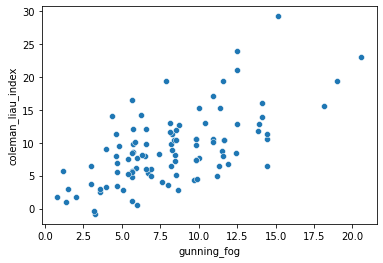

In [ ]:
# researchers/linguists try to quantify complexity/grade level
# take two approaches, see if there is relative agreement
# variance tends to increase > 10
sns.scatterplot(x="gunning_fog", y="coleman_liau_index", data=tweets_df)


In [ ]:
##################################### Your turn
##

## use article to grab entries
## source, and generate a pandas dataframe with readability comparisons 
## establish concepts as features for downstream tasks, potentially

URL1 = "https://www.bbc.com/culture/article/20211117-why-u2s-one-is-the-ultimate-anthem"
URL2 = "https://www.theonion.com/dollar-dangling-from-fishing-line-sure-does-look-entici-1848019332"
URL3 = "https://www.nytimes.com/2021/11/20/world/china-congo-cobalt-explained.html"

# general flow
# article = Article()
# download and then parse methods on the article
# use the .text attribute


In [ ]:
articles = []

article = Article(URL1)
article.download(); article.parse();
articles.append(article.text)

article = Article(URL2)
article.download(); article.parse();
articles.append(article.text)

article = Article(URL3)
article.download(); article.parse();
articles.append(article.text)




['The song continued to evolve during the Zoo TV tour, as Bono introduced an extra verse, which came to him out of nowhere one night in North Carolina in March 1992. Known to fans as Hear Us Coming, it asks God a series of questions, ending with, "Do you hear us scratching/ Will you make us crawl?" "It allows a chance for anger and the focus of that wrath is best kept for religion itself," Bono says. "In the Hebrew Bible, this level of spleen is allowed in the imprecatory psalms: King David shouting at God." He once said that this turned One into "sort of a protest song against God, from a believer": yet another take on a father and a son.\n\nIn January 1993, Michael Stipe and Mike Mills of REM teamed up with Mullen and Clayton under the name Automatic Baby to play One at an MTV Rock the Vote concert to celebrate Bill Clinton\'s inauguration. Bill Flanagan describes the scene in his fly-on-the-wall book U2 at the End of the World: "When Stipe sings, \'We\'re one but we\'re not the same

In [ ]:
docs = nlp.pipe(articles)

# extract to a dataframe
articles_df = td.extract_df(docs, metrics="readability")

In [ ]:
articles_df

,text,flesch_reading_ease,flesch_kincaid_grade,smog,gunning_fog,automated_readability_index,coleman_liau_index,lix,rix
0,The song continued to evolve during the Zoo TV...,75.029716,8.259602,10.052491,11.470455,9.741378,8.036648,40.039773,3.96875
1,"BRATTLEBORO, VT—Rubbing his hands together in ...",78.313636,8.191948,8.418075,10.883117,9.709532,7.105697,36.298701,3.00000
2,The five biggest Chinese mining companies in C...,69.606379,8.022337,10.924579,11.337931,10.353046,10.998084,43.670498,4.62069


In [ ]:
## FUN PRACTICE AND THOUGHT EXERCISE - SHREK MOVIE TRANSCRIPT
## You could practice and think about readbility by using the Shrek transcript
## lets think about the reading model:  https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index
## are we supplying a proper dataset if we use the Shrek movie transcript?  does it make sense directionally, use as index and not absolutes?


In [ ]:
##################################### Intent Classification within spacy
## I mentioned everything will start to show a concept of frameowrks
##
## we already saw spacy has pipelines
## we can also extend the objects, in this case, the Doc object
## we will set an extension on a Doc that will apply the 


In [ ]:
# tokenwiser is a fantastic abstraction layer for some pre-processing tasks
# it also created the bridge for us to plug sklearn models into spacy
# as a doc extension

from tokenwiser.extension import sklearn_method

In [ ]:
# get the data training dataset for sms spam

SQL = "SELECT * from `questrom.SMSspam.train`"
train = pd.read_gbq(SQL, "questrom")


In [ ]:
train.tail(3)

,message,label,id
3832,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,spam,4240
3833,Had your contract mobile 11 Mnths? Latest Moto...,spam,4245
3834,This is the 2nd time we have tried 2 contact u...,spam,4259


In [ ]:
# lets build a pipeline from sklearn to classify the messages

steps = [("cv", CountVectorizer()), 
         ("clf", DecisionTreeClassifier(max_depth=7, 
                                        min_samples_leaf=15, 
                                        min_samples_split=30, 
                                        random_state=820))]

pipe = Pipeline(steps)


In [ ]:
# fit the model - use spacy to 
pipe.fit(train.message, train.label)

Pipeline(steps=[('cv', CountVectorizer()),
                ('clf',
                 DecisionTreeClassifier(max_depth=7, min_samples_leaf=15,
                                        min_samples_split=30,
                                        random_state=820))])

In [ ]:
# play with the model
sms = "Hey, how are ya!?!"
pipe.predict([sms])
pipe.predict_proba([sms])

array([[0.97609181, 0.02390819]])

In [ ]:
# review the classes
pipe.classes_

array(['ham', 'spam'], dtype=object)

In [ ]:
# lets set this as a property

from spacy.tokens import Doc
Doc.set_extension("spam", getter=sklearn_method(pipe))

In [ ]:
# lets play around

doc = nlp(sms)


In [ ]:
# simple print
doc

Hey, how are ya!?!

In [ ]:
type(doc)

spacy.tokens.doc.Doc

In [ ]:
doc._.spam

{'ham': 0.9760918074593561, 'spam': 0.023908192540643927}

In [ ]:
# we could always roll our own without tokenwiser attribute 

def spam_cat(doc):
  label = pipe.predict([doc.text[0]])
  label = str(label[0])
  return label

Doc.set_extension("label", getter=spam_cat)


In [ ]:
doc = nlp(sms)

In [ ]:
doc._.label

'ham'

In [ ]:
##################################### Lets zoom out
##
## we are fitting a classifier with python
## we are showing that we COULD include it in a spacy pipeline.  This is helpful is spacy is at the core of a stack
## spacy is very powerful, as we will continue to use spacy for NER tasks and embeddings
## 
## Classification has a broad range of applications
## news categories for content sorting
## customer service requests
## chatbots (what is the user asking for)    <------ Rasa, in part, uses spacy to help build chatbots
## topic classification   <-------- There is topic modeling, but I have always felt like ML classifiation task are better for all sorts of problems
##   --- we will see a form of this when we jump into embedding representations of text
##
## 

In [ ]:
##################################### a domain-specific ML approach
## 
## Work in your capstone groups - you should be working in teams, not by yourself
##
## When it comes to things like sentiment, sometimes its better to annotate and build our own classifier
## 
## What does this mean?
## 1. collect a dataset
## 2. annotate the data with our own business rules
##  --------> Label studio?
## 3. we can use some of the tools above 
## ---------> generate a score, define a threshold, give labels
## ---------> fit a model on labels
## ---------> review, iterate, review, iterate
##
## Why build our own?
## 
## - out of the box generalize (thats a theme you have heard me say)
## - domain specific words may not be captured
## - also, sarcasm is hard to detect even with modifier approaches like TextBlob or Vader
##
## 
## there is an airlines tweets dataset on biq query
## bring in questrom.datasets.airlines-tweets
## just the tweet_id, airline_sentiment, airline, and text columns
##
## NOTES:  You can use any model you like
##         You DO NOT have to use spacy, just highligting that these tools can be play well together
## 
## after you make predictions, are there any differences by airline?
